# Introduction

<img src=img/gw_fabric.jpg>

Gravitational waves (GWs) were predicted by Einstein's General Theory of Relatively over a 100 years ago. In 2015, the Laser Interferometer Gravitational-wave Observatory (LIGO) made the first direct detection of gravitational waves produced by a merger of 2 black holes, GW150914.

GWs, unlike electromagnetic radiation i.e. light, don't just travel through space but instead are ripples in the fabric of spacetime itself. They are caused by highly energetic mergers of very massive astrophysical objects like binary black holes and neutron stars. The wave causes the fabric of spacetime to stretch and squeeze thus changing the distances between points in spacetime. The LIGO detectors measure this change in distance using laser interferometers as a 1d timeseries called the "strain".

The strength of the GW is very high near these massive objects in spacetime but by the time they reach Earth the spacetime in which the detector sits is only deformed by less than 10^-21 m; that's smaller than the diameter of a proton!

<img src=img/gw_event.jpg>

Thus GW signals are very elusive and we need highly sensitive detectors to detect them. However, due to the exquisite sensitivity of the LIGO detectors they are susceptible to all kinds of terrestrial noise despite state-of-the-art noise isolation. Therefore, LIGO uses multiple detectors - one is located in Livingston, Louisiana and another in Hanford, Washington along with the VIRGO detector in Italy - to observe GW events and verifies detections through coincident events across the network of detectors. 

<img src=img/gw_detector_network.jpg>

As you'll see the GW signals is often not perceptible to the eye in the time-domain "strain" data due to the low signal-to-noise ratio (SNR). LIGO uses traditional matched-filtering approach to search for GW signals in the strain timeseries of each detector by matching segments of data with a large bank of precomputed templates of signals from known sources. 

In this project, we will use deep learning techniques instead to train a binary classifier which can predict whether there is a GW signals in a data segment or not. 

This notebooks walks through the dataset and the end-to-end modeling pipeline. The current implementation is in PyTorch.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.0.0
True
3


### Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os, collections, datetime, copy

import numpy as np
import pandas as pd

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_DIR = "/data/rgura001/ML4GWsearch/g2net-gravitational-wave-detection"
RESULTS_DIR = PROJECT_DIR+"/results"
RUN_DIR = RESULTS_DIR+'/nbrun_{}'.format(datetime.datetime.now().strftime("%Y%m%d"))
if not os.path.exists(RUN_DIR):
    os.makedirs(RUN_DIR+"/plots")
print(RUN_DIR)

/data/home/rgura001/ML4GWsearch/results/nbrun_20231114


# Exploratory Data Analysis (EDA)

Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

`train/` - the training set files, one npy file per observation; labels are provided in a files shown below

`test/` - the test set files; you must predict the probability that the observation contains a gravitational wave. WE WILL NOT USE THIS.

_`training_labels.csv`_ - target values of whether the associated signal contains a gravitational wave

### Load sample IDs

In [4]:
training_samples = pd.read_csv(DATA_DIR+'/training_labels.csv')
print(training_samples.columns)
print(collections.Counter(training_samples['target']))
print(training_samples.shape)

Index(['id', 'target'], dtype='object')
Counter({0: 280070, 1: 279930})
(560000, 2)


Approximately equal no. of positive and negative samples. 

### Load a sample

In [5]:
from utils import convert_image_id_2_path

path = convert_image_id_2_path(training_samples['id'][0])
print(path)
x = np.load(path)
print(x.shape)

/data/rgura001/ML4GWsearch/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy
(3, 4096)


### Visualize a sample from both classes

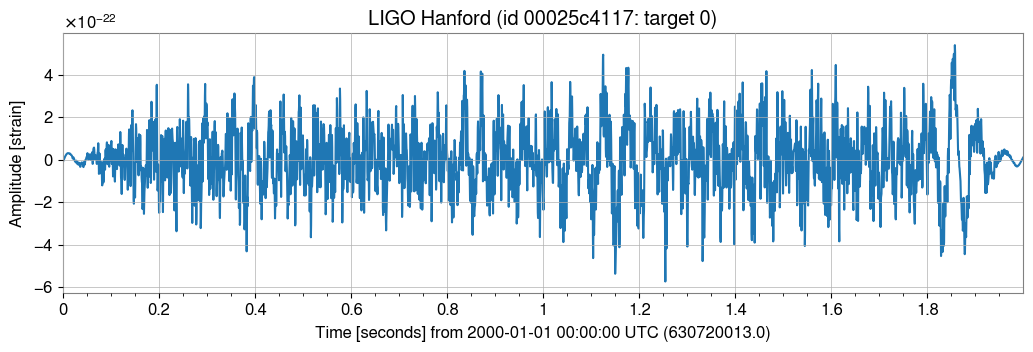

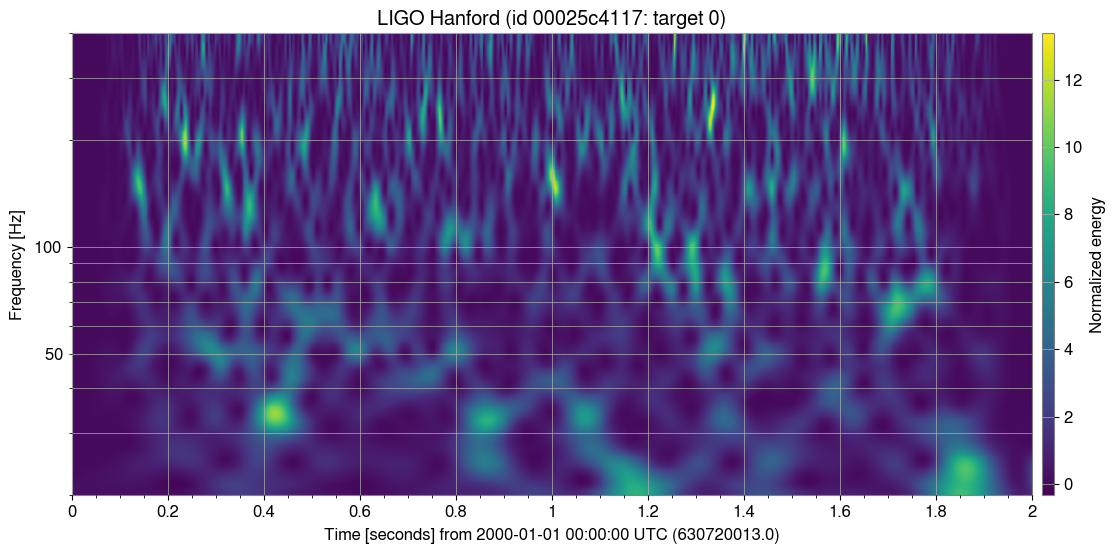

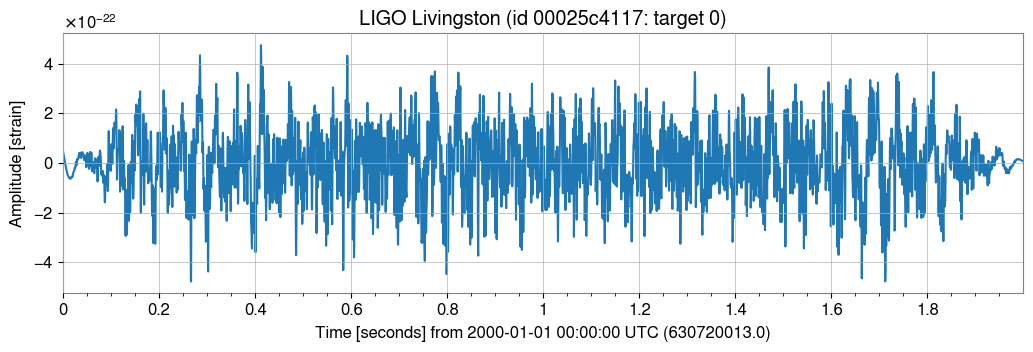

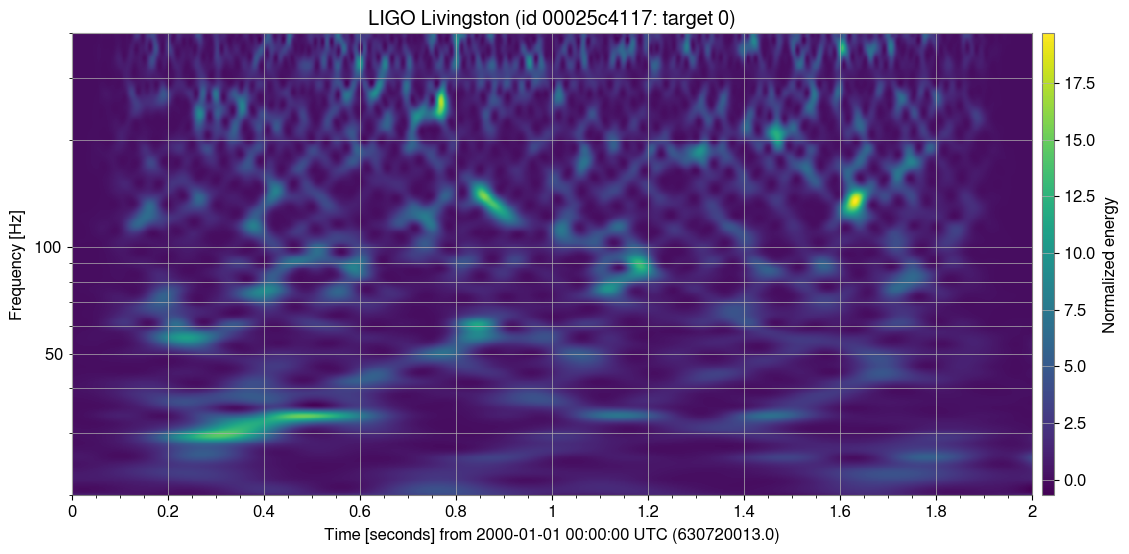

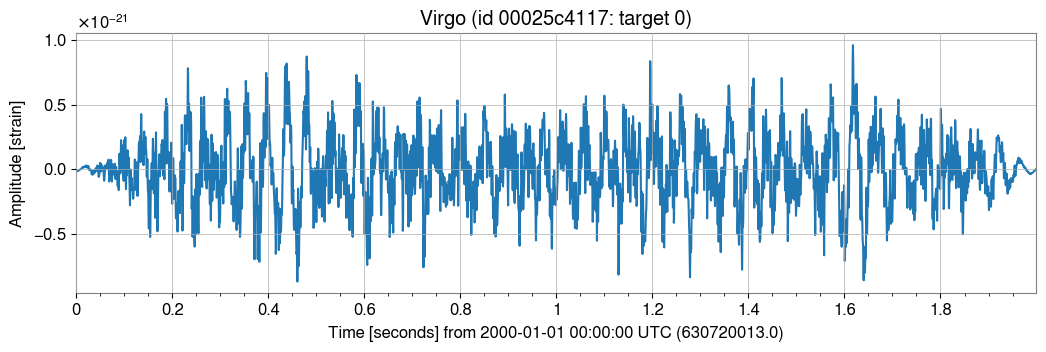

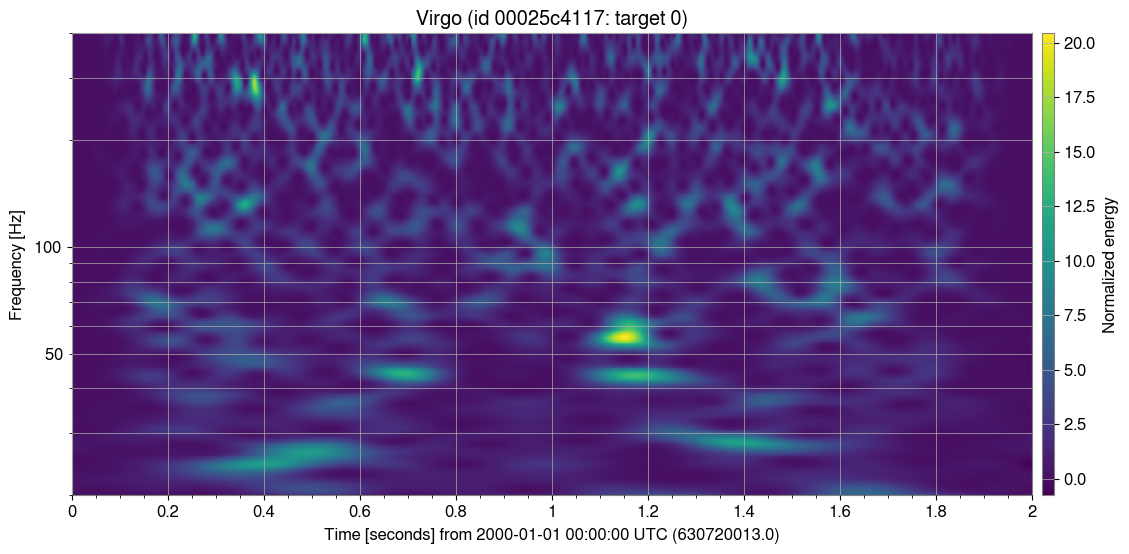

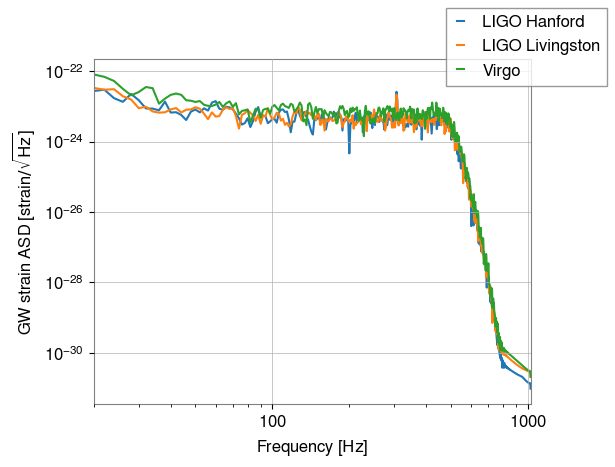

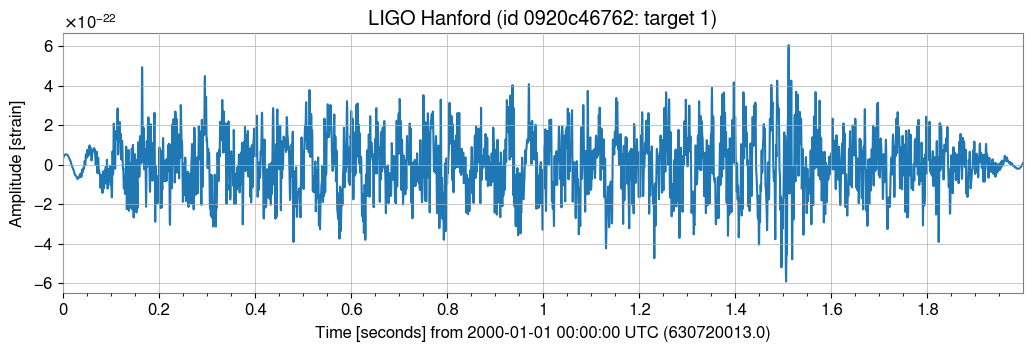

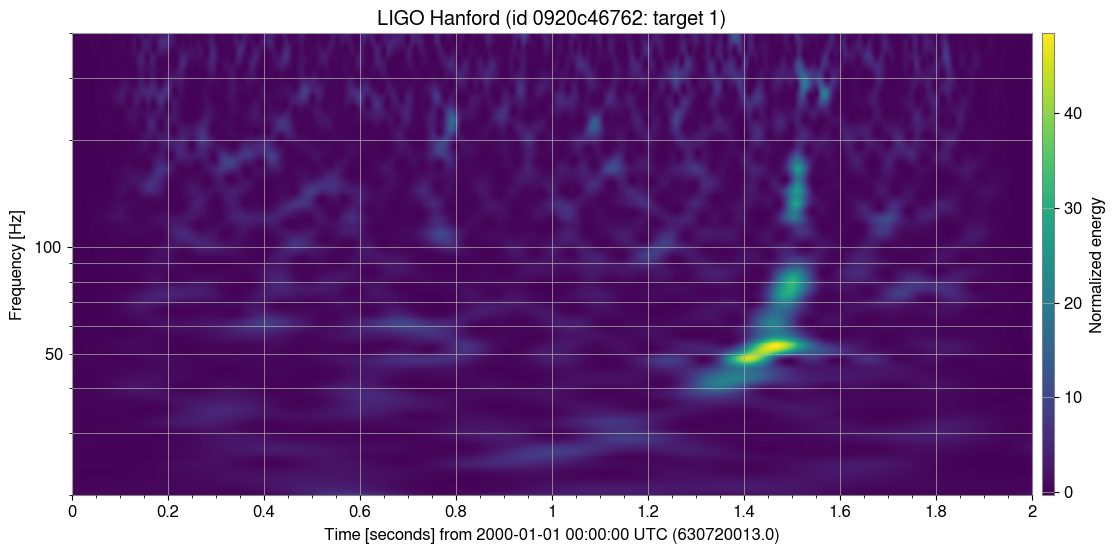

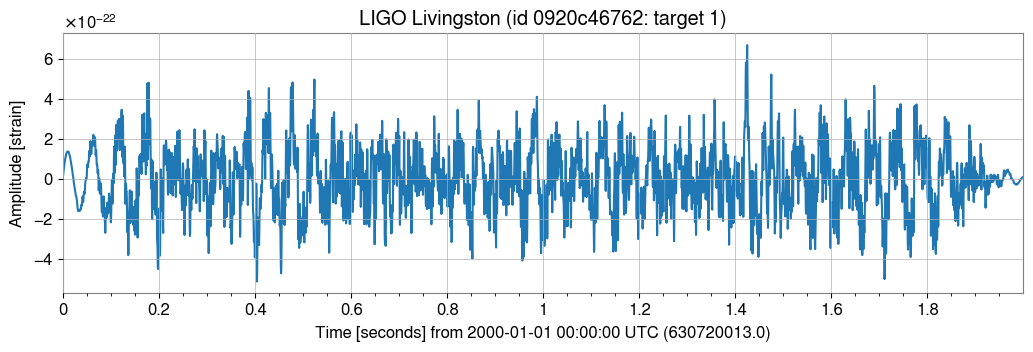

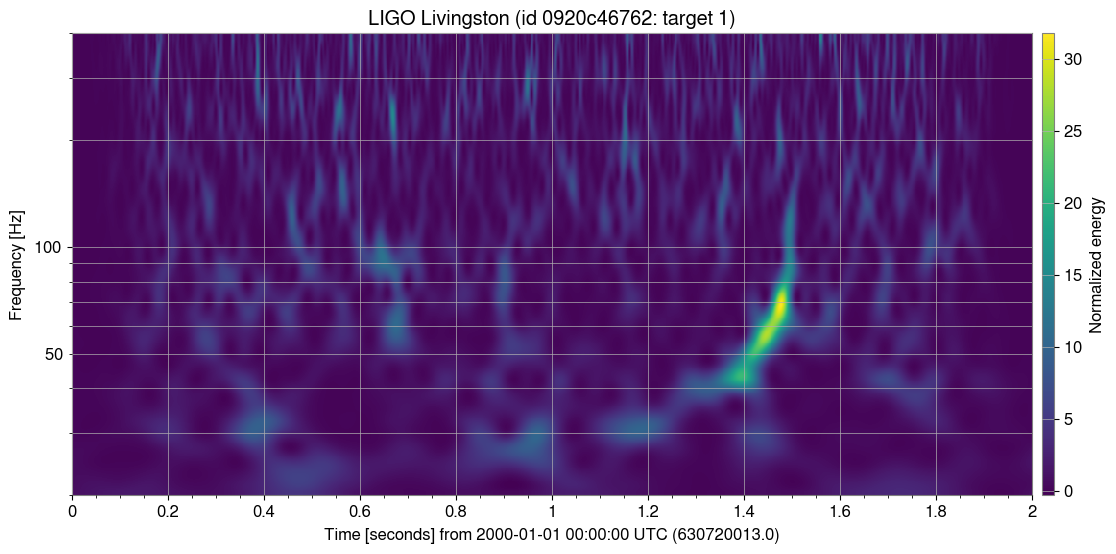

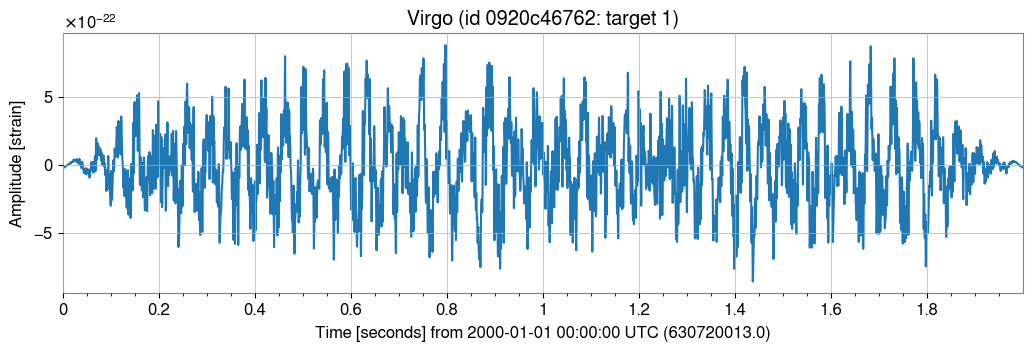

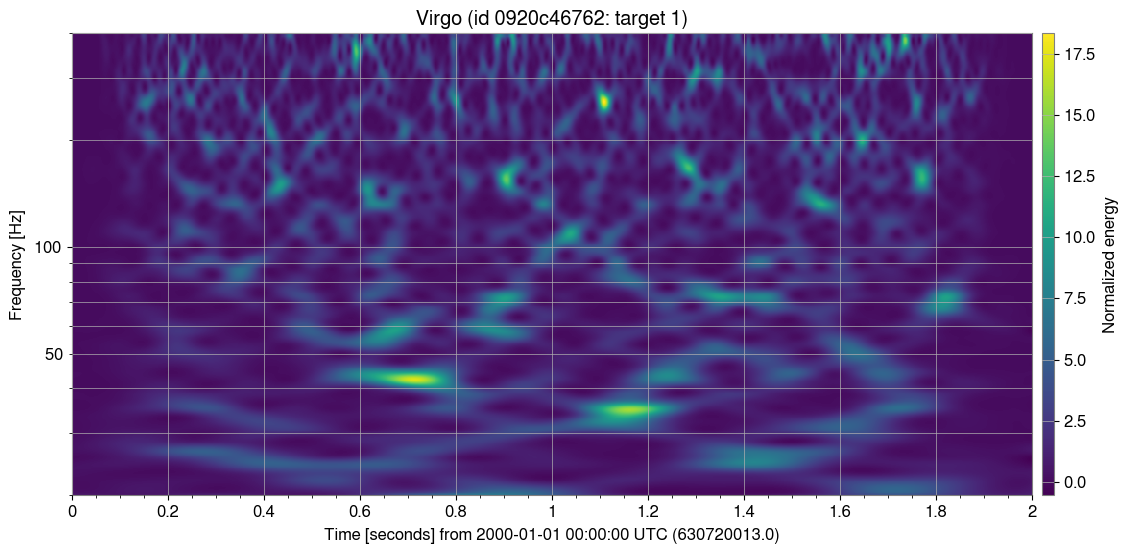

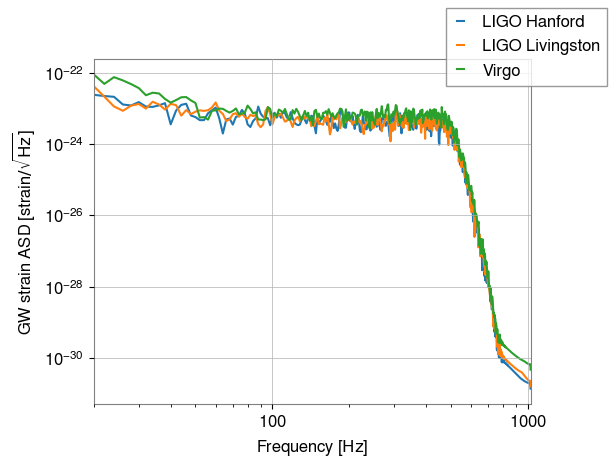

In [8]:
import utils
# sample_size = 1
positive_sample_ids = training_samples[training_samples.target == 1]['id'] #.sample(sample_size)
negative_sample_ids = training_samples[training_samples.target == 0]['id'] #.sample(sample_size)

highpass, z_norm = False, False
whiten = False
bandpass, scale = True, False

k=10
for _id in negative_sample_ids[k:k+1]:
    utils.plot_sample_ts(_id=_id, target=0, bandpass=bandpass, scale=scale, highpass=highpass, z_norm=z_norm, ts_whiten=whiten)
    # utils.visualize_sample(_id, 0)

k=10000
for _id in positive_sample_ids[k:k+1]:
    utils.plot_sample_ts(_id=_id, target=1, bandpass=bandpass, scale=scale, highpass=highpass, z_norm=z_norm, ts_whiten=whiten)
    # utils.visualize_sample(_id, 1)

In this positive sample (id=0920c46762) there is an obvious "chirp" noticable in the first 2 detectors. (Note: I can only see this if I set some very specific parameters in the Q-transfrom and these maybe different from sample to sample.)

The ASD plot show that Virgo is less sensitive than LIGO, especially at lower frequencies (< 20 Hz), with different noise characteristic. So the params in spectrogram that work for LIGO won't work for Virgo data... Also motivates the need to process/encode data from different IFOs separately(?)

### Compare against a real GW event

In [12]:
from gwpy.time import to_gps, from_gps
from gwpy.timeseries import TimeSeries, TimeSeriesDict

start_time, end_time = float(to_gps('2015-09-14T09:50:29')), float(to_gps('2015-09-14T09:51:01'))
outseg_start, outseg_end = float(to_gps('2015-09-14T09:50:45.2')), float(to_gps('2015-09-14 09:50:45.5'))

hdata = TimeSeries.fetch_open_data('H1', start_time, end_time)
ldata = TimeSeries.fetch_open_data('L1',  start_time, end_time)
print(hdata.sample_rate, ldata.sample_rate)

## G2Net dataset is samples at 2048, original LIGO strain is sampled at 4k (fastest 16k)
# hdata = hdata.resample(2048.0)
# ldata = hdata.resample(2048.0)
# print(hdata.sample_rate, ldata.sample_rate)

from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]
zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt=True)
lfilt = ldata.filter(zpk, filtfilt=True)

hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1)) 

ldata = ldata.crop(*ldata.span.contract(1))
lfilt = lfilt.crop(*lfilt.span.contract(1)) 

4096.0 Hz 4096.0 Hz


#### LIGO Hanford

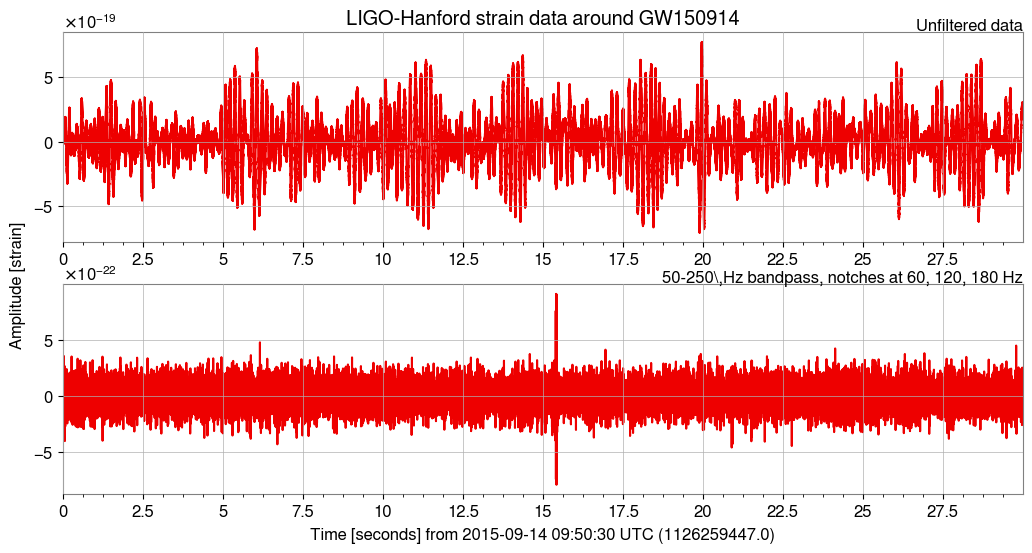

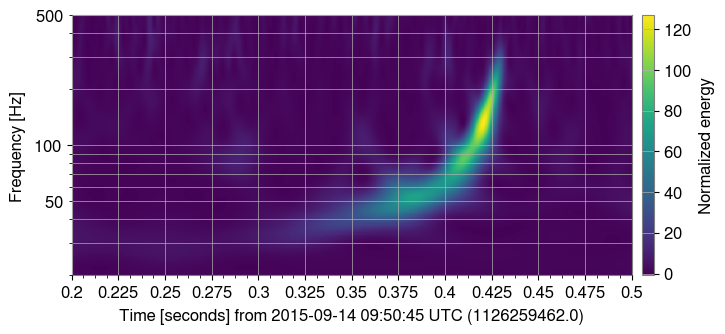

In [13]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

plot = hdata.q_transform(outseg=(outseg_start, outseg_end)).plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

#### LIGO Livingston

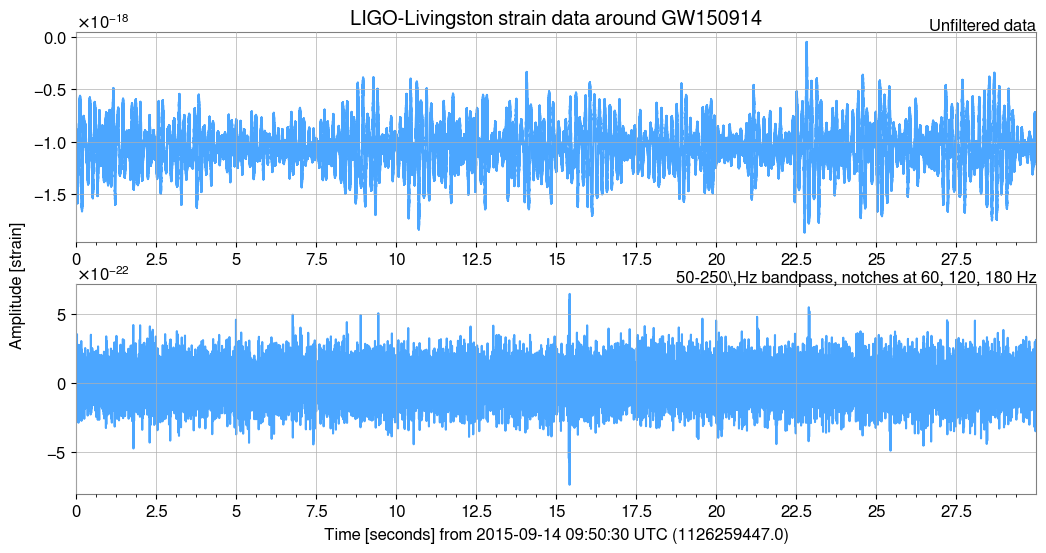

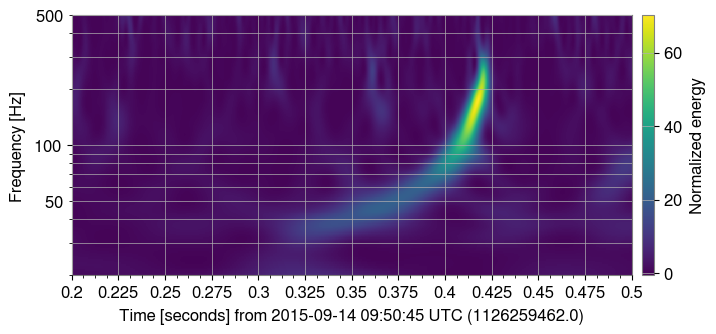

In [8]:
from gwpy.plot import Plot
plot = Plot(ldata, lfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-livingston')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Livingston strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

plot = ldata.q_transform(outseg=(outseg_start, outseg_end)).plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()



#### ASDs of data from LHO and LLO

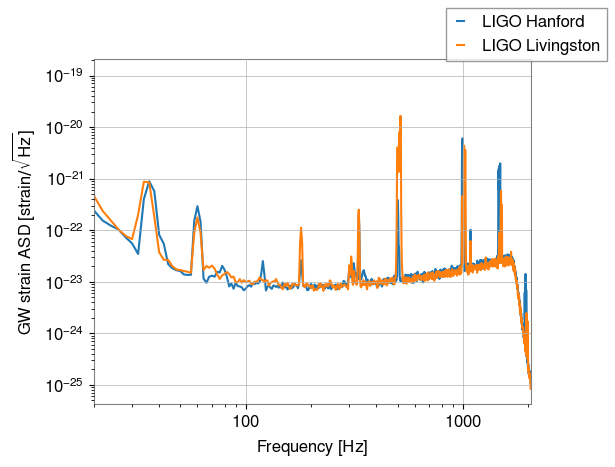

In [9]:
asd_dict = TimeSeriesDict({
                        'LIGO Hanford': hdata.asd(0.5, 0.01),
                        'LIGO Livingston': ldata.asd(0.5, 0.01)
                    })
plot = asd_dict.plot(label='key')
ax = plot.gca()
ax.set_xlim(20, 0.5*hdata.sample_rate.value)
# ax.set_ylim(1e-25, 1e-22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]')
plot.legend()
plot.show()

Sensitivity of LHO and LLO was comparable when GW150914 was observed.

# DL Pipeline: PyTorch

This following is just a walk-through. For proper training and hyperparameter tuning use train.py, train_pl.py or wandb_sweep.py.

In [7]:
device = 'cuda:1'

## Data Loader

This returns a PyTorch dataloaders for train, val and test sets along with their metadata. Each sample will be a batch of timeseries -> (batch_size, in_channels, sequence_length). Since the dataset contains data samples from 3 different detectors, you can choose to load a sample with data from any subset of detectors by passing appropriate parameters in `ifo`. You can also choose to preprocess the each timeseries by highpassing 20 Hz and/or z-normalizing the timeseries. Experiments show I need to do both for good performance.

In [18]:
from dataloaders.dataloader import get_dataloaders
batch_size=128
ifos=["LIGO Hanford", "LIGO Livingston"]

train_dataloader, \
    val_dataloader, \
        test_dataloader,\
             [train_df, val_df, test_df] \
                = get_dataloaders(DATA_DIR=DATA_DIR,
                                    batch_size=batch_size, 
                                    sample_size=batch_size*100,
                                    ifos=ifos,
                                    highpass=True,
                                    z_norm=True,
                                    rng_seed=42
                                )
print(len(train_df), collections.Counter(train_df['target']))
print(len(val_df), collections.Counter(val_df['target']))
print(len(test_df), collections.Counter(test_df['target']))


9600 Counter({0: 4827, 1: 4773})
1920 Counter({1: 960, 0: 960})
1280 Counter({0: 664, 1: 616})


In [19]:
# train_batch = next(iter(train_dataloader))
# train_data, train_labels, train_ids = train_batch
# print("Test Samples\nData: {} {}\nLabels: {} {}".format(train_data.shape, train_data.dtype, 
#                                                 train_labels.shape, train_labels.dtype))
# target_1_idxes = np.where(train_labels == 1)[0]
# target_0_idxes = np.where(train_labels == 0)[0]
# print(target_1_idxes, target_0_idxes)

## Model

Currently I am just borrowing a ResNet model implemnted in `tsai` to get baseline performance.

In [21]:
from models.tsai.tsai.models.ResNet import ResNet

n_classes = 2
input_channels = len(ifos) # datapoint is a univariate timeseries
# seq_length = int(4096 / input_channels) # datapoint duration is 2 s sampled at 2048 Hz.
seq_length = 4096

model = ResNet(input_channels, n_classes, nf=64).to(device)

In [22]:
from torchinfo import summary

model_stats = summary(model=model, input_size=(batch_size,input_channels,seq_length), 
                        verbose=0, device=device)
summary_str = str(model_stats)
with open(RUN_DIR+"/model_summary.txt", 'w') as f:
    f.write(summary_str)
model_stats

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 2]                  --
├─ResBlock: 1-1                          [128, 64, 4096]           --
│    └─ConvBlock: 2-1                    [128, 64, 4096]           --
│    │    └─Conv1d: 3-1                  [128, 64, 4096]           896
│    │    └─BatchNorm1d: 3-2             [128, 64, 4096]           128
│    │    └─ReLU: 3-3                    [128, 64, 4096]           --
│    └─ConvBlock: 2-2                    [128, 64, 4096]           --
│    │    └─Conv1d: 3-4                  [128, 64, 4096]           20,480
│    │    └─BatchNorm1d: 3-5             [128, 64, 4096]           128
│    │    └─ReLU: 3-6                    [128, 64, 4096]           --
│    └─ConvBlock: 2-3                    [128, 64, 4096]           --
│    │    └─Conv1d: 3-7                  [128, 64, 4096]           12,288
│    │    └─BatchNorm1d: 3-8             [128, 64, 4096]           128
│  

## Training

This is just a generic PyTorch training loop.

In [23]:
from torch.nn import functional as F
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, 
                            momentum=0.9, nesterov=True,
                            weight_decay=0.0)
def cross_entropy_loss(logits, labels):
  return F.cross_entropy(logits, labels)
  # return F.nll_loss(logits, labels)

from early_stopping import ValLossEarlyStopping, TrainValLossDiffEarlyStopping
# early_stopping = TrainValLossDiffEarlyStopping(tolerance=10, min_delta=0.5)
early_stopping = ValLossEarlyStopping(patience=10, min_delta=1e-5)

In [24]:
num_epochs = 100
log_interval = 10
stop_early=False

epoch_train_losses = []
epoch_val_losses = []
for epoch in range(num_epochs):
    
    ## Train Step
    batch_train_losses = []
    for batch_idx, (x, y, id_) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)
        logits = model(x) #.to(device)
        train_loss = cross_entropy_loss(logits, y)

        batch_train_losses.append(train_loss)
    
        train_loss.backward()
        optimizer.step()

    epoch_train_loss = torch.mean(torch.tensor(batch_train_losses))
    epoch_train_losses.append(epoch_train_loss.cpu().detach().numpy())
    
    ## Val Step
    with torch.no_grad():
        batch_val_losses = []
        for batch_idx, (x, y, id_) in enumerate(val_dataloader):
            x, y = x.to(device), y.to(device)
            logits = model(x) #.to(device)
            val_loss = cross_entropy_loss(logits, y)
            batch_val_losses.append(val_loss)
        epoch_val_loss = torch.mean(torch.tensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.cpu().detach().numpy())
        
        if epoch % log_interval == 0:
            print("Epoch {}: train loss = {}, val loss = {}".format(epoch+1, epoch_train_loss, epoch_val_loss))
    
    if stop_early:
        ## Early Stopping
        # early_stopping(epoch_train_loss, epoch_val_loss)
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break


Epoch 1: train loss = 0.6938485503196716, val loss = 0.6928015351295471
Epoch 11: train loss = 0.6895105242729187, val loss = 0.6902992129325867
Epoch 21: train loss = 0.686496376991272, val loss = 0.6880136132240295
Epoch 31: train loss = 0.6838881373405457, val loss = 0.685728907585144
Epoch 41: train loss = 0.6813832521438599, val loss = 0.6835037469863892
Epoch 51: train loss = 0.6781793236732483, val loss = 0.6808218359947205
Epoch 61: train loss = 0.6718973517417908, val loss = 0.6758067011833191
Epoch 71: train loss = 0.6557862162590027, val loss = 0.662725567817688
Epoch 81: train loss = 0.6344231367111206, val loss = 0.6455393433570862
Epoch 91: train loss = 0.615708589553833, val loss = 0.6350744366645813


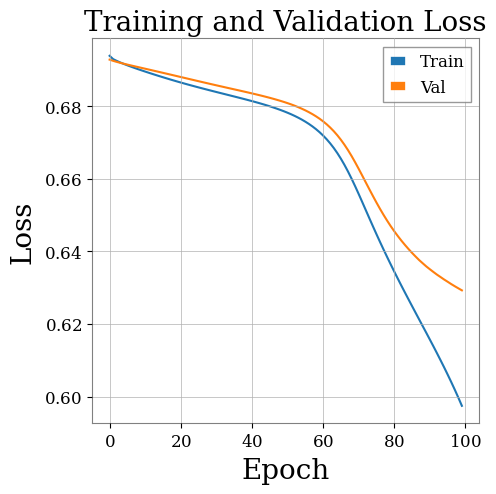

In [25]:
## Plot training and validation loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(epoch_train_losses)), epoch_train_losses, label='Train')
ax.plot(range(len(epoch_val_losses)), epoch_val_losses, label='Val')
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.set_title('Training and Validation Loss', fontsize=20)
ax.legend()
plt.show()  

## Evaluation

In [26]:
model.eval()
with torch.no_grad():
    test_labels = []
    test_preds = []
    test_preds_proba = []
    for batch_idx, (x, y, id_) in enumerate(test_dataloader):
        test_labels.extend(y.cpu().detach().numpy())
        x, y = x.to(device), y.to(device)
        logits = model(x)
        logits = logits.cpu().detach().numpy()
        # logits = np.exp(logits)
        preds = np.argmax(logits, axis=1)
        test_preds.extend(preds)
        test_preds_proba.append(logits)
    
    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    test_preds_proba = np.concatenate(test_preds_proba, axis=0)

print(test_labels.shape, test_preds.shape, test_preds_proba.shape)

(1280,) (1280,) (1280, 2)


Saving results in /data/home/rgura001/ML4GWsearch/results/nbrun_20230915/plots
                    precision    recall  f1-score      support
no_signal(class 0)   0.645248  0.725904  0.683203   664.000000
signal(class 1)      0.658537  0.569805  0.610966   616.000000
accuracy             0.650781  0.650781  0.650781     0.650781
macro avg            0.651892  0.647854  0.647085  1280.000000
weighted avg         0.651643  0.650781  0.648439  1280.000000


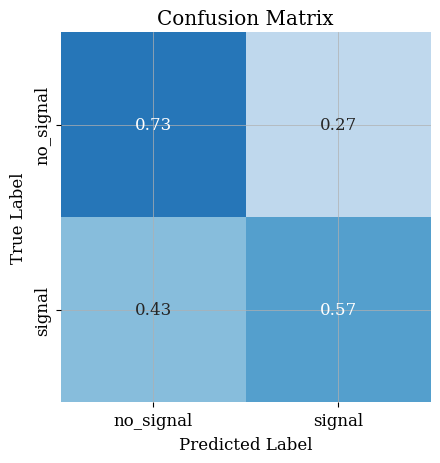

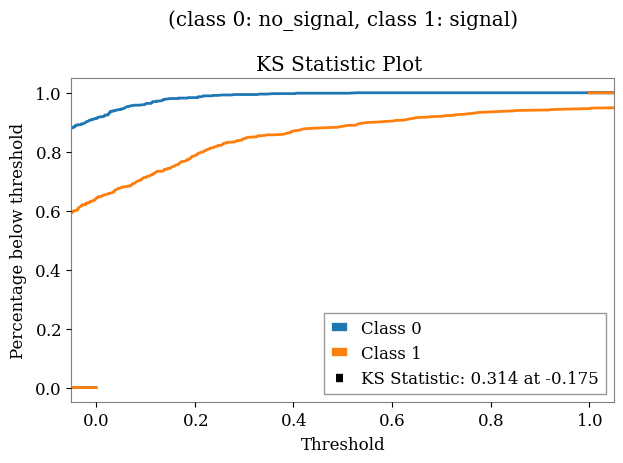

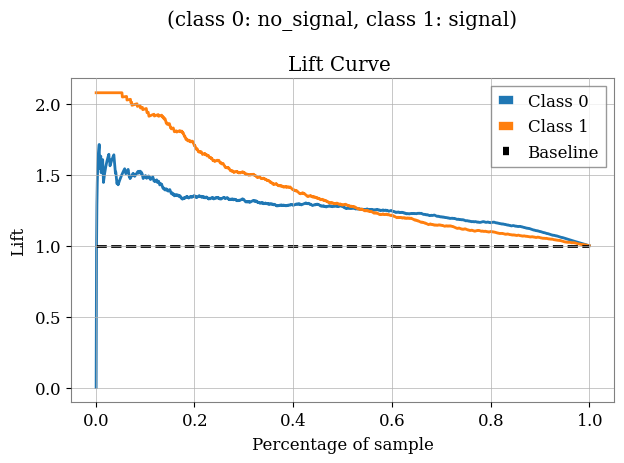

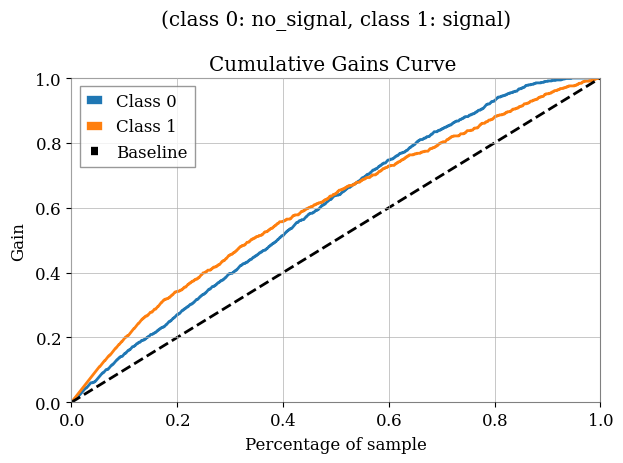

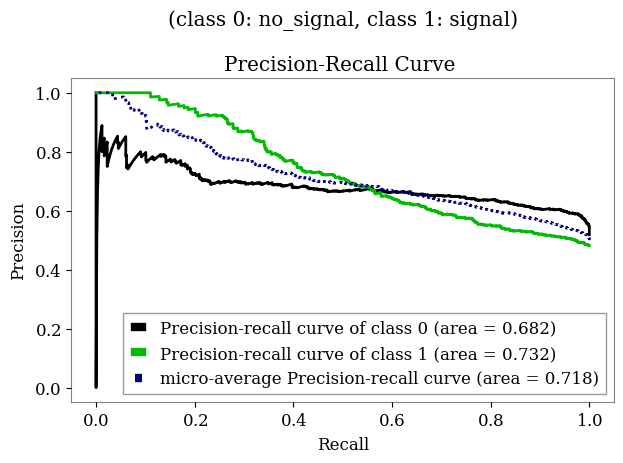

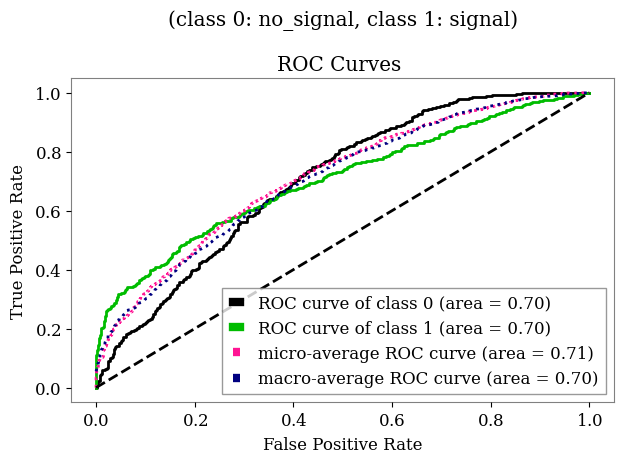

In [27]:
from clfutils4r.eval_classification  import eval_classification
eval_classification(class_names=['no_signal','signal'],
        y_test=test_labels, y_pred=test_preds, y_pred_proba=test_preds_proba,
        save=True, RESULTS_DIR=RUN_DIR+'/plots',
        show=True
        )

## Save model to disk

In [15]:
checkpoint = {'model': model, 'model_state_dict': model.state_dict(),'optimizer': optimizer,'optimizer_state_dict': optimizer.state_dict()}
torch.save(checkpoint, RUN_DIR+"/saved_model.pth")

## Load saved model from disk

In [ ]:
saved_model_dict = torch.load(RUN_DIR+"/saved_model.pth")
saved_model = saved_model_dict['model']
saved_model.load_state_dict(saved_model_dict['model_state_dict'])
optimizer = saved_model_dict['optimizer']
optimizer.load_state_dict(saved_model_dict['optimizer_state_dict'])

## Just checking
saved_model.eval()
with torch.no_grad():
    test_labels = []
    test_preds = []
    test_preds_proba = []
    for batch_idx, (x, y, id_) in enumerate(test_dataloader):
        test_labels.extend(y.cpu().detach().numpy())
        x, y = x.to(device), y.to(device)
        logits = saved_model(x)
        logits = logits.cpu().detach().numpy()
        # logits = np.exp(logits)
        preds = np.argmax(logits, axis=1)
        test_preds.extend(preds)
        test_preds_proba.append(logits)
    
    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    test_preds_proba = np.concatenate(test_preds_proba, axis=0)

print(test_labels.shape, test_preds.shape, test_preds_proba.shape)

from clfutils4r.eval_classification import eval_classification
eval_classification(class_names=['no_signal','signal'],
           y_test=test_labels, y_pred=test_preds, y_pred_proba=test_preds_proba,
            # save=True, RESULTS_DIR=RUN_DIR,
            show=True
        )